In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [ ]:

train = pd.read_csv('/content/drive/My Drive/Data zindi/AIMS_Train.csv')
test = pd.read_csv('/content/drive/My Drive/Data zindi/AIMS_Test.csv')
submission = pd.read_csv('/content/drive/My Drive/Data zindi/AIMS_SampleSubmission.csv')

In [ ]:
print(train.MRG.value_counts(dropna = False), 'Train length:', len(train), '\n')
print(test.MRG.value_counts(dropna = False), 'Test length:', len(test))

NO    646214
Name: MRG, dtype: int64 Train length: 646214 

NO    114038
Name: MRG, dtype: int64 Test length: 114038


In [ ]:
train.drop(['user_id', 'MRG',], 1, inplace = True)
test.drop(['user_id', 'MRG',], 1, inplace = True)


In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:

data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']

In [ ]:
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})

In [ ]:
#RETURN THE AVERAGE OF THE MONTH/TENURE BOUNDARIES
data['TENURE_avg'] = data['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2, 'G 12-15 month':(12+15)/2,
                                             'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})

In [ ]:
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']

In [ ]:
region = data.groupby('REGION').mean()
region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='REGION', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [ ]:

data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data['freq*segment'] = data['FREQUENCE'] * data['ARPU_SEGMENT']

data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

In [ ]:
data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
data['net/reg'] = data['ON_NET'] / data['REGULARITY']
data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']

In [ ]:
data['reg_log'] = np.log1p(data['REGULARITY'])
data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
data['data_log'] = np.log1p(data['DATA_VOLUME'])
data['montant_log'] = np.log1p(data['MONTANT'])
data['rev_log'] = np.log1p(data['REVENUE'])
data['freq_log'] = np.log1p(data['FREQUENCE'])

In [ ]:
data['reglog-montlog'] = data['reg_log'] - data['montant_log']
data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
data['tenure/rechlog'] = data['TENURE_avg'] / data['rech_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

In [ ]:
drop = ['REGION', 'TOP_PACK']
data.drop(drop, 1, inplace = True)

In [ ]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

================================Fold1====================================
0:	test: 0.9244592	best: 0.9244592 (0)	total: 384ms	remaining: 1h 3m 58s
50:	test: 0.9295213	best: 0.9295356 (49)	total: 16.5s	remaining: 53m 31s
100:	test: 0.9300482	best: 0.9300482 (100)	total: 32.1s	remaining: 52m 30s
150:	test: 0.9303121	best: 0.9303121 (150)	total: 47.1s	remaining: 51m 15s
200:	test: 0.9304444	best: 0.9304444 (200)	total: 1m 2s	remaining: 50m 23s
250:	test: 0.9305256	best: 0.9305256 (250)	total: 1m 16s	remaining: 49m 29s
300:	test: 0.9305733	best: 0.9305744 (298)	total: 1m 31s	remaining: 48m 58s
350:	test: 0.9306082	best: 0.9306082 (350)	total: 1m 45s	remaining: 48m 27s
400:	test: 0.9306377	best: 0.9306380 (399)	total: 2m	remaining: 48m 2s
450:	test: 0.9306521	best: 0.9306562 (442)	total: 2m 15s	remaining: 47m 47s
500:	test: 0.9306788	best: 0.9306802 (496)	total: 2m 29s	remaining: 47m 21s
550:	test: 0.9306946	best: 0.9306948 (544)	total: 2m 43s	remaining: 46m 51s
600:	test: 0.9307018	best: 0

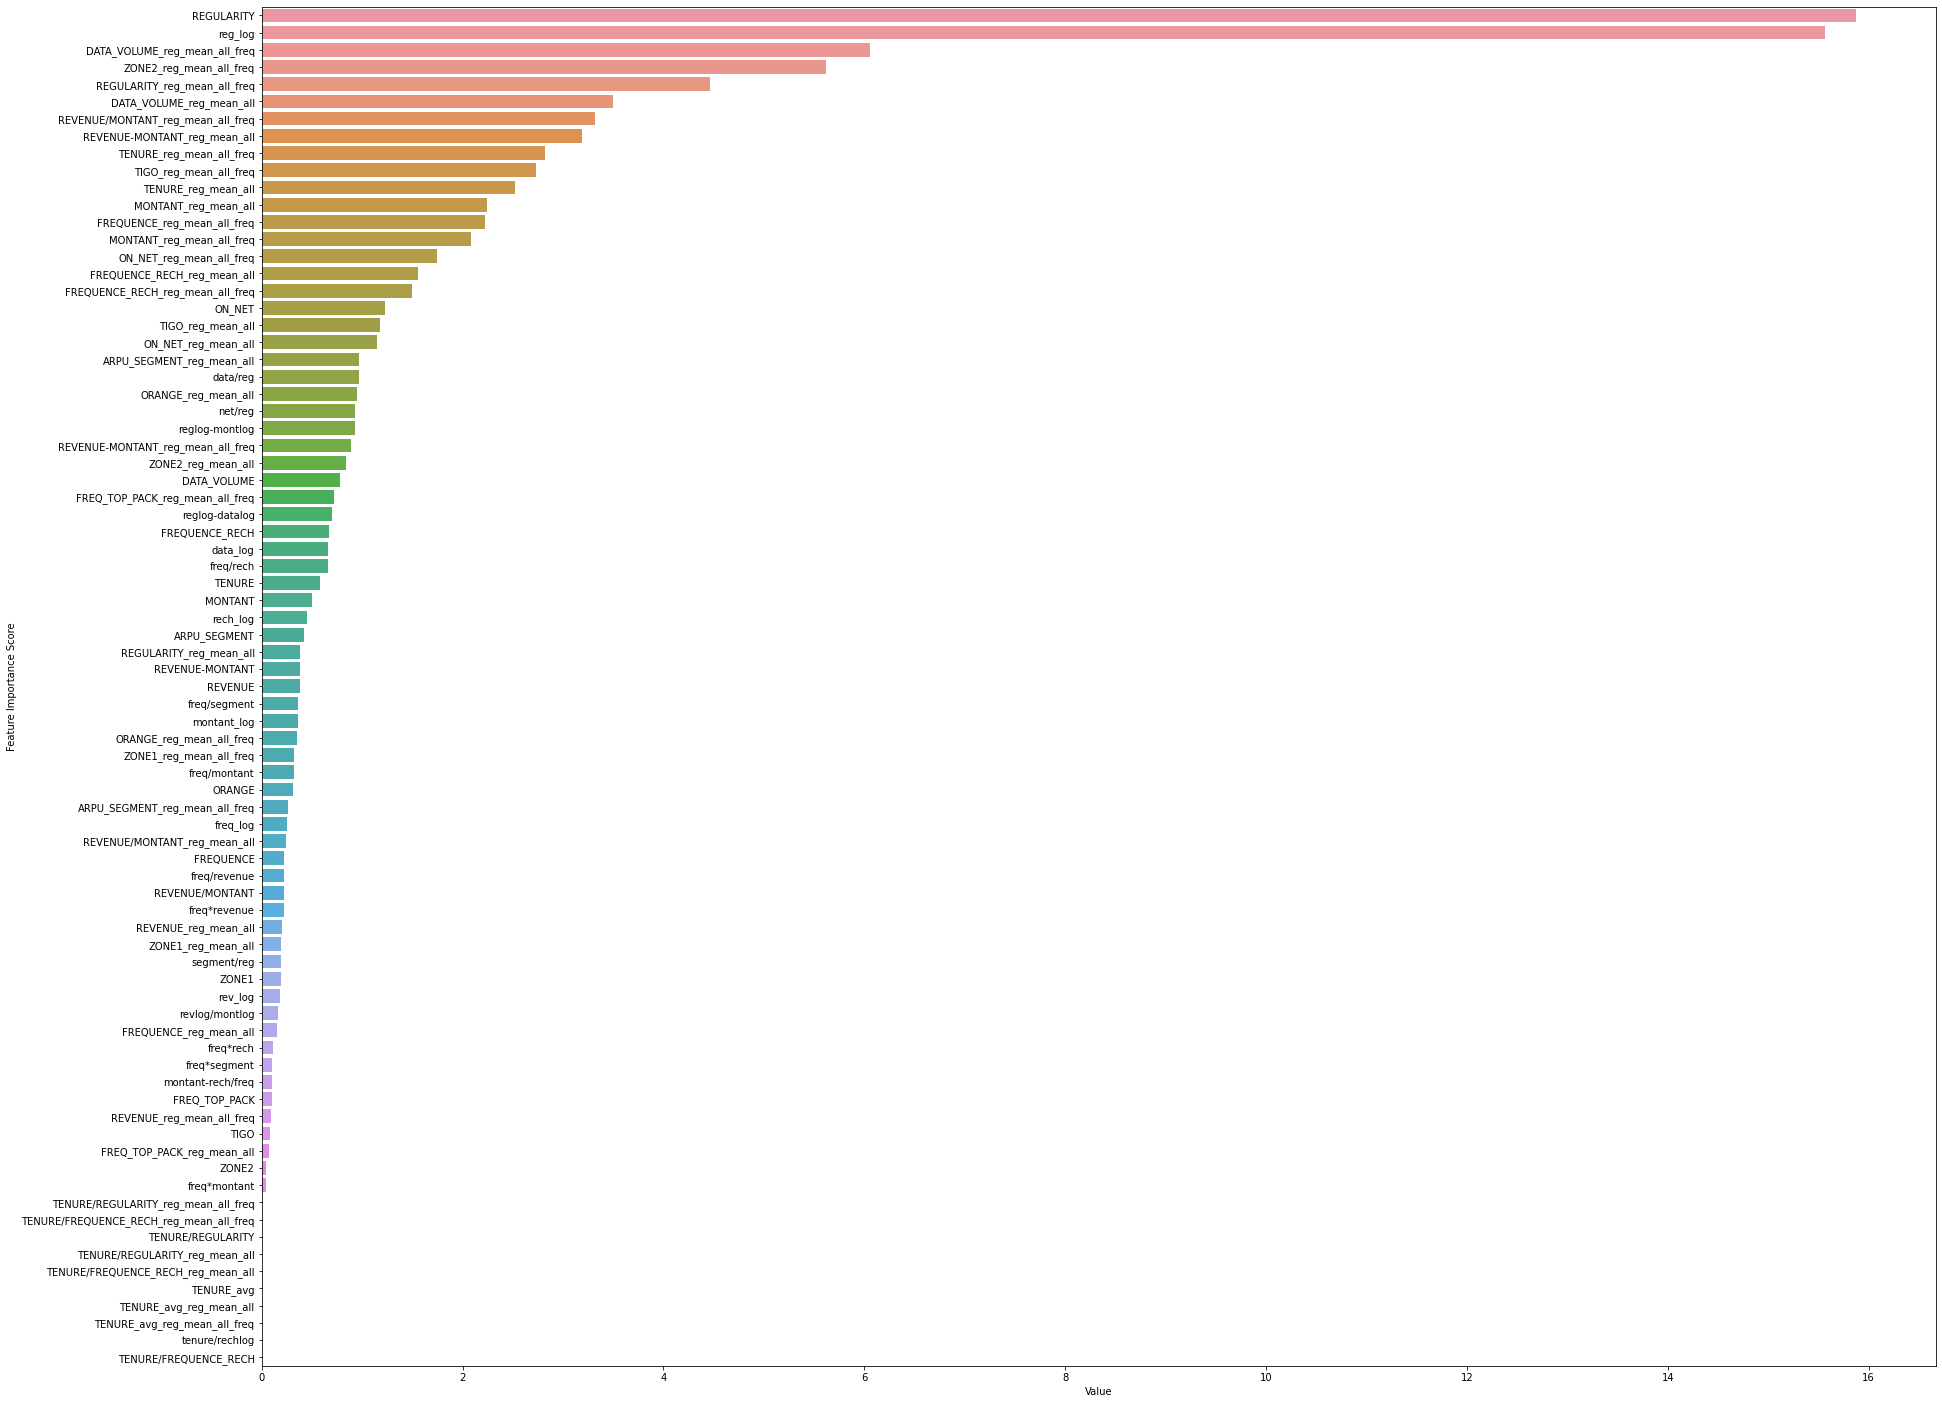

0.9312138024497767 0.9320122219213353 0.000353685546533599


In [ ]:

catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
[0]	validation_0-auc:0.891551
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.921389
[2]	validation_0-auc:0.923128
[3]	validation_0-auc:0.923527
[4]	validation_0-auc:0.923629
[5]	validation_0-auc:0.923841
[6]	validation_0-auc:0.924371
[7]	validation_0-auc:0.92458
[8]	validation_0-auc:0.92482
[9]	validation_0-auc:0.924988
[10]	validation_0-auc:0.92514
[11]	validation_0-auc:0.925201
[12]	validation_0-auc:0.925937
[13]	validation_0-auc:0.926399
[14]	validation_0-auc:0.926426
[15]	validation_0-auc:0.926445
[16]	validation_0-auc:0.926868
[17]	validation_0-auc:0.927288
[18]	validation_0-auc:0.927345
[19]	validation_0-auc:0.927872
[20]	validation_0-auc:0.928168
[21]	validation_0-auc:0.928184
[22]	validation_0-auc:0.928339
[23]	validation_0-auc:0.928375
[24]	validation_0-auc:0.928408
[25]	validation_0-auc:0.928812
[26]	validation_0-auc:0.928825
[27]	validation_0-auc:0.928841
[28]	va

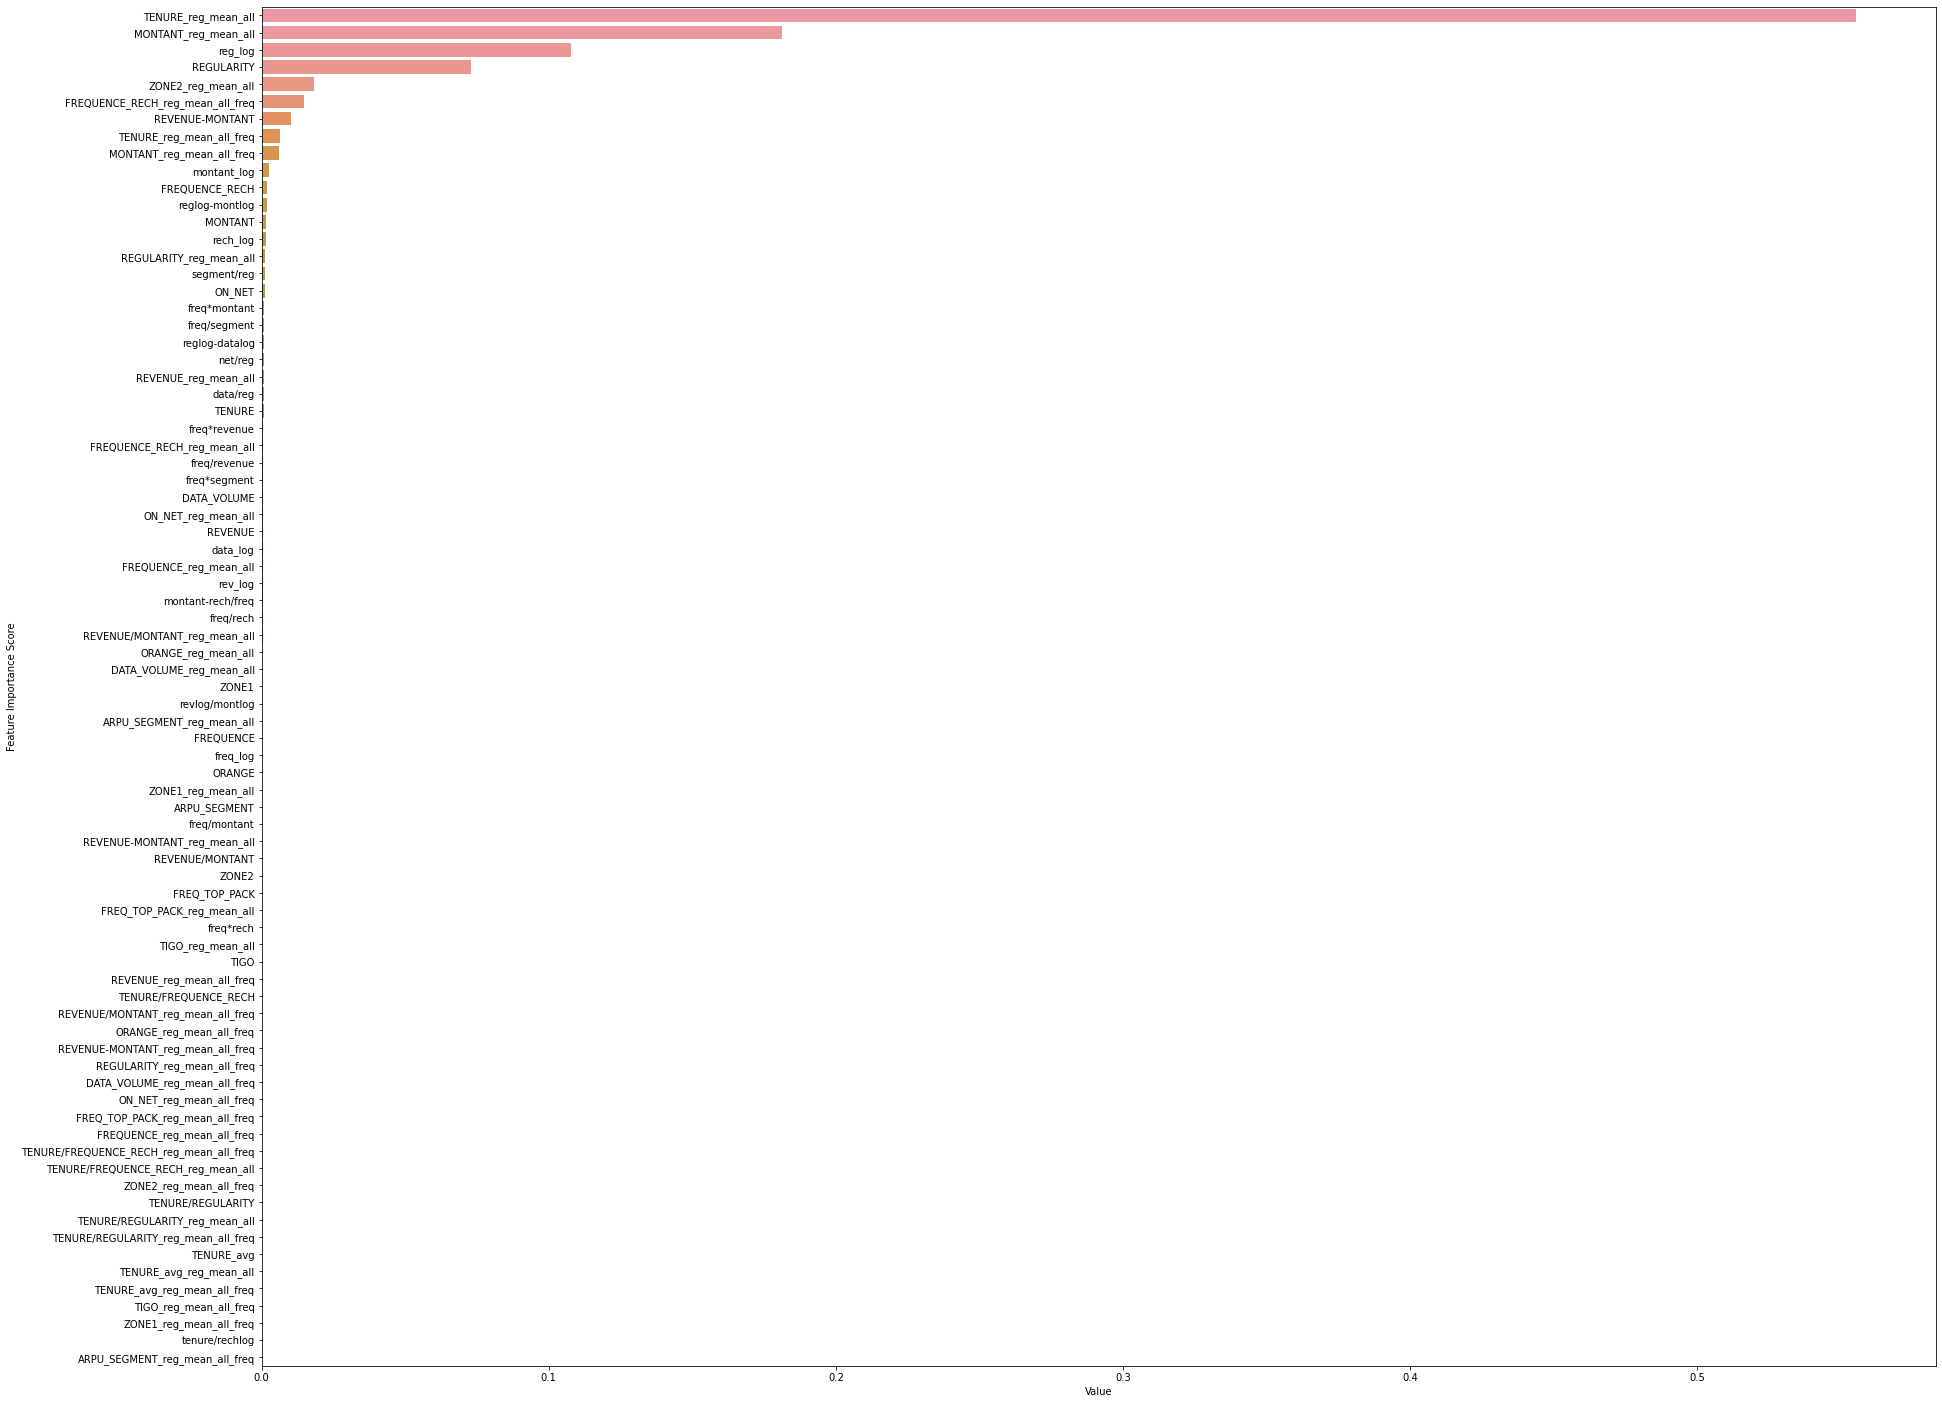

0.9311349468606778 0.9324380359676369 0.00033059486348999785


In [ ]:

xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.927169
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.927766
[3]	valid_0's auc: 0.927921
[4]	valid_0's auc: 0.928018
[5]	valid_0's auc: 0.928071
[6]	valid_0's auc: 0.928113
[7]	valid_0's auc: 0.928621
[8]	valid_0's auc: 0.92873
[9]	valid_0's auc: 0.928798
[10]	valid_0's auc: 0.928882
[11]	valid_0's auc: 0.928902
[12]	valid_0's auc: 0.929346
[13]	valid_0's auc: 0.929367
[14]	valid_0's auc: 0.929379
[15]	valid_0's auc: 0.929395
[16]	valid_0's auc: 0.929416
[17]	valid_0's auc: 0.92945
[18]	valid_0's auc: 0.929787
[19]	valid_0's auc: 0.929955
[20]	valid_0's auc: 0.929985
[21]	valid_0's auc: 0.929982
[22]	valid_0's auc: 0.930137
[23]	valid_0's auc: 0.930147
[24]	valid_0's auc: 0.930173
[25]	valid_0's auc: 0.930182
[26]	valid_0's auc: 0.93021
[27]	valid_0's auc: 0.930239
[28]	valid_0's auc: 0.930259
[29]	valid_0's auc: 0.930272
[30]	valid_0's auc: 0.930273
[31]	v

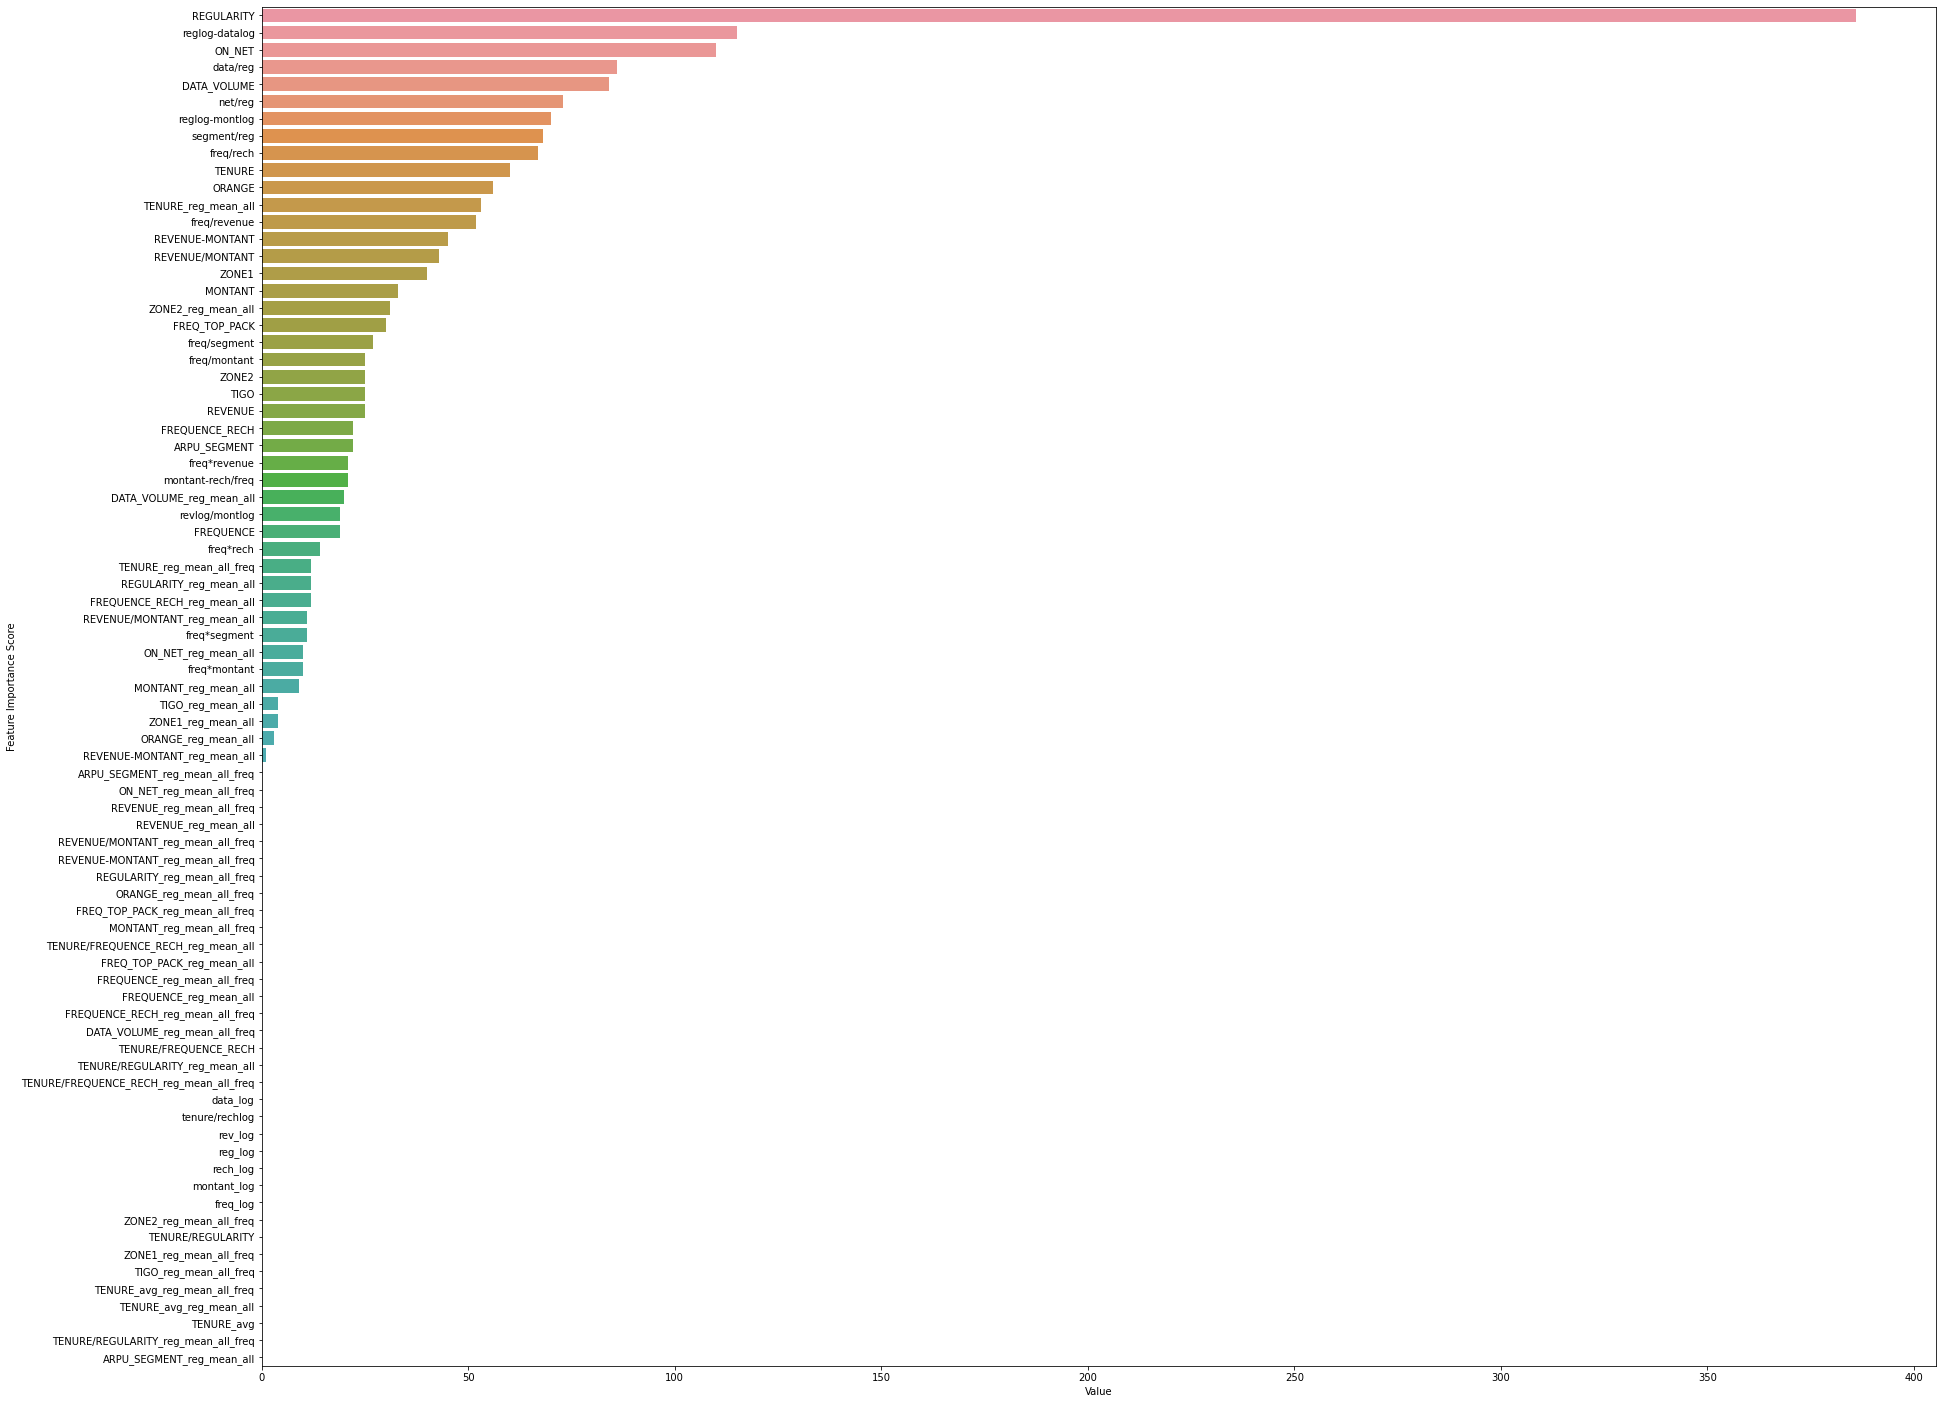

0.9311374437644864 0.9326387465989635 0.00035938765691915137


In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)


In [ ]:

submission['CHURN'] = predict

submission.to_csv('Subsmission.csv',index=False)

In [ ]:
predict

array([3.04635421e-04, 4.87614336e-02, 1.46517745e-04, ...,
       1.84095683e-03, 5.71453141e-04, 7.89484168e-01])